# Inside Airbnb 2022 (4 Jan 2022)

### Importing Packages
Here, I am taking the main packages from throughout the practicals as well as some of the functions that Jon uses

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# These are specific to NLP
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [3]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [4]:
# This is the Plotting Function Jon wrote
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

In [5]:
#This is used in NLP to convert string object to be compatible with markdown
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

### Reading in the Data

In [6]:
listings2022 = pd.read_csv('listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {listings2022.shape[0]:,} x {listings2022.shape[1]}")

FileNotFoundError: [Errno 2] No such file or directory: 'listings.csv.gz'

In [ ]:
# adding the borough data
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

### General Data Cleaning: Booleans, Dates, Categories, Price Strings, Geography
Most of this code comes from practical 5

In [ ]:
# Here I am parametrising the data by defining the columns so I can work with them more easily. This comes from the FSDS practical 5.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

#### Booleans

In [ ]:
# columns that seem to have values that should be booleans
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [ ]:
# Here I want to find which columsn have t/f as a value and should be booleans, check how to do this because I just went into the excel doc
#listings2022.filter(regex=("t"))

In [ ]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
for b in bcols:
    print(f"Converting {b}")
    listings2022[b] = listings2022[b].replace({'f':False, 't':True}).astype('bool')

In [ ]:
print(listings2022.has_availability.dtype)
#all seem to be booleans but idk why that didn't improve the memory

In [ ]:
shm = listings2022.host_is_superhost.memory_usage(deep=True) # Super Host Memory
bhm = listings2022.host_is_superhost.replace({'f':False, 't':True}).astype('bool').memory_usage(deep=True) # Boolean Host Memory

print(f"The raw memory usage of `host_is_superhost` is {shm/1000:,.0f} Kb.")
print(f"The boolean memory usage of `host_is_superhost` is {bhm/1000:,.0f} Kb.")
print(f"That's {(bhm/shm)*100:.0f}% of the original!")

In [ ]:
listings2022.sample(5, random_state=43)[bcols]

#### Dates

In [ ]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']
listings2022.sample(5, random_state=43)[dates]

In [ ]:
for d in dates:
    print("Converting " + d)
    listings2022[d] = pd.to_datetime(listings2022[d], infer_datetime_format=True)

In [ ]:
# This checks that we successfully changed the dates for each
for d in dates:
    print(listings2022[d].dtype, "\n")
    print(listings2022.sample(5, random_state=45)[d].dt.strftime('%A %B %d, %Y'))

#### Categories

In [ ]:
# converting to categories, here I am selecting the columns that use categorical data so we can groupby better
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']
listings2022.sample(5, random_state=42)[cats]

In [ ]:
listings2022[cats[0]].value_counts()

In [ ]:
for c in cats:
    print(f"Converting {c}")
    listings2022[c] = listings2022[c].astype('category')

In [ ]:
print(listings2022[cats[3]].cat.categories.values)

#### Price and String Values

In [ ]:
money = ['price']
listings2022.sample(10, random_state=42)[money]

In [ ]:
for m in money:
    print(f"Converting {m}")
    listings2022[m] = listings2022[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')
# part of the issue here was that you had to remove the commas as well because it wouldn't convert to a float if you just removed the $

In [ ]:
print(listings2022.price.dtype)

In [ ]:
print(len(listings2022[listings2022['price'] == 0]))

In [ ]:
priceis0 = (listings2022[listings2022['price'] == 0])

In [ ]:
priceis0.head(19)[['id','name','price','neighbourhood_cleansed']]

#### Converting other Values to Pandas Integers

In [ ]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        listings2022[i] = listings2022[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        listings2022[i] = listings2022[i].astype('float').astype(pd.UInt16Dtype())

In [ ]:
#exporting cleaned file, this comes from practical 5 too

In [ ]:
# path = os.path.join('data','raw') # A default location to save raw data
# fn   = listings2022
# print(f"Writing to: {fn}")

In [ ]:
# testing = True

# if testing:
#     listings2022 = pd.read_csv(os.path.join(path,'listings_2022.csv.gz'), 
#                 low_memory=False, usecols=cols, nrows=10000)
# else:
#     listings2022 = pd.read_csv(os.path.join(path,'listings_2022.csv.gz'), 
#                 low_memory=False, usecols=cols)

# print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

In [ ]:
# path = os.path.join('data','clean')

# if not os.path.exists(path):
#     print(f"Creating {path} under {os.getcwd()}")
#     os.makedirs(path)
    
# listings2022.to_csv(os.path.join(path,'listings_2022.csv'.replace('.csv','-testing.csv' if testing else '.csv')), index=False)
# print("Done.")

In [ ]:
# listings2022.reset_index().to_feather(os.path.join(path,'listings_2022.csv'.replace('.csv.gz','-testing.feather' if testing else '.feather')))

In [ ]:
# Making the Longitude and Latitude in Geographically Usable Data

print(f"The bottom-left corner is {listings2022.longitude.min()}, {listings2022.latitude.min()}")
print(f"The top-right corner is {listings2022.longitude.max()}, {listings2022.latitude.max()}")

geo_listings2022 = gpd.GeoDataFrame(listings2022,geometry=gpd.points_from_xy(listings2022 .longitude, listings2022 .latitude, crs='epsg:4326'))
geo_listings2022.to_crs('epsg:27700')

#check the type
print(type(geo_listings2022))
print(type(geo_listings2022.geometry))
geo_listings2022.price.head

### Saving Cleaned Data Files

In [ ]:
# Save general cleaned data
#listings2022.to_csv('2022listingsclean.csv')

In [ ]:
# Save spatial cleaned data
#geo_listings2022.to_csv('geo_2022listingsclean.csv')

### NaNs and Nulls

In [ ]:
# #check for na
# listings2022[~(geo_listings2022.price.str.startswith('$', na=False))]

In [ ]:
# listings2022.info(verbose=True)

In [ ]:
# #check for columns with most na values but here I will sort them in descending order to get a better visual sense
# listings2022.isna().sum().sort_values(ascending=False).head(45)

In [ ]:
# #drop listings with na ID values (this is more for the process because there don't appear to be any with no ID)
# listings2022.drop(listings2022[listings2022.id.isna()].index.array, axis=0, inplace=True)

In [ ]:
# #count the null values by the row
# listings2022.isnull().sum(axis=1).sort_values(ascending=False).head(20)

In [ ]:
# #the "problem" rows that have a lot of nan values
# probs = listings2022.isnull().sum(axis=1)

In [ ]:
# probs.plot.hist(bins=30)

Thoughts: we should not uses neighbourhood as a field or any about the reviews because we will lose so many listings. Also we should not use info about bathrooms, liscence (does that mean all the listings don't have licenses or they're not displayed? if so, maybe that could be a policy to show they're complying). A substantial amount of hosts do not list a location - also leads to the question if a host might have multiple locations?

Before dropping these na values, it might make sense to select the columns you want so you don't accidentally drop a row of a listing that has data you want but an na value in one row. I.e., it has an nan in "review_scores_checkin" but we might accidentally delete it. We should clean the date rows and then maybe remove the ones that don't have dates. We need to be more purposefull about which rows we drop (i.e., we can drop rows that have a na date for "calendar_last_scraped" if we don't think that row is more generally valuable)

We should also chat about which fields should be categorical - i.e., I feel like neighbourhoods should be because we will want to group by them. The host_location field might be a bit more complicated because it is not cleaned like the neighbourhood one. It has 1519 values/locations. Maybe we should use a regex to make these categorical by host country?


So, we should drop the following:

### Focused Cleaning
cols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'property_type', 'rom_type','price', 'accomodates' 'minimum_nights', 'maximum_nights']

In [ ]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type','price', 'minimum_nights', 'maximum_nights', 'geometry']
geo_listings2022_cleaned = geo_listings2022[fcols]

In [ ]:
geo_listings2022_cleaned.head(5)

In [ ]:
geo_listings2022_cleaned.info(verbose=True)

In [ ]:
# count the null values by the column
gl22 = geo_listings2022_cleaned
gl22.isna().sum().sort_values(ascending=False).head(10)

In [ ]:
# count the null values by the row
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

In [ ]:
probrows = gl22.isnull().sum(axis=1) > 1
null_rows = gl22[probrows]
null_rows.head(20)

In [ ]:
gl22 = gl22.dropna(thresh=len(gl22.columns)-1)
print(f"The dataset now has {gl22.shape[0]:,} rows after dropping those with more than 1 null value")

In [ ]:
#Check that it worked
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

Here I will create a subset of these listings by boroughs of interest:

Least Deprived:
Haringey
Kensington and Chelsea (kc for shorthand)

Middle:
Camden

Most Deprived:
Sutton
Merton

In [ ]:
boros_oi = ['Haringey','Kensington and Chelsea','Camden', 'Sutton', 'Merton']
#boros_oi stands for "boroughs of interest"
#I tried making a for loop for this but couldn't figure it out... this should do the same thing though

Haringey = gl22[gl22.neighbourhood_cleansed.str.contains(r'Haringey', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Haringey.shape[0]:,} listings in the cleaned geodataset for listings in Haringey")

kc = gl22[gl22.neighbourhood_cleansed.str.contains(r'Kensington and Chelsea', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {kc.shape[0]:,} listings in the cleaned geodataset for listings in Kensington and Chelsea")

Camden = gl22[gl22.neighbourhood_cleansed.str.contains(r'Camden', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Camden.shape[0]:,} listings in the cleaned geodataset for listings in Camden")

Sutton = gl22[gl22.neighbourhood_cleansed.str.contains(r'Sutton', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Sutton.shape[0]:,} listings in the cleaned geodataset for listings in Sutton")

Merton = gl22[gl22.neighbourhood_cleansed.str.contains(r'Merton', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Merton.shape[0]:,} listings in the cleaned geodataset for listings in Merton")

### NLP Analysis
This code draws from practical 7

Here, I target descriptions using text mining analysis with the aim of discerning Airbnb listings that might be tied to gentrification. I do this first in terms of london more generally then on the subsets of data for specific boroughs.

Because I am working on NLP, I will drop all the description rows that have null values because I will primarily be working with the descriptions.

In [ ]:
gdf = gl22.dropna(subset=['description'])
print(f"Now gdf has {gdf.shape[0]:,} rows.")

In [ ]:
gdf[~gdf.description.isna()].description.sample(10, random_state=42)
#It seems there are more or less the same issues as in the practical regarding the descriptions

In [ ]:
gdf.description.iloc[56440]
#While many of the above end in ..., the dots do not appear to be part of the actual description but rather a way of shortening it

##### Cleaning the Description Text
1. Removing HTML
2. Case
3. Removing Punctuation

In [ ]:
# #make lowercase
dcol = gdf['description']
gdf['description'] = dcol.apply(lambda x: x.lower())

In [ ]:
# #remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf['description']:
    punkt.append(re.sub(pattern, ' ', l))

In [ ]:
# for p in punkt:
#     as_markdown("Line of Text", p)

In [ ]:
gdf.description.sample(5, random_state=42)
# #for some reason the removal of punct didn't stick...

Below, I am using the package 'textual' written for practical 7 that should do more or less the same thing as above. However, it will go further to remove stopwords, words with accents, special characters, digits, as well as lemmatise the text. This *could* double count some of the lower case, removal of punct and html that I've already done OR it could just be sure it worked. But, I think it's important to have done that above because it ended up catching more listings (about 100) than without the NLP.

In [ ]:
#Regex for words often associated with gentrification:
gent = gdf[gdf.description.str.contains(r'\b(?:trend(?:y|iness|ing)|revitalize|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
gent1 = gent.iloc[0:1000, :]
gent2 = gent.iloc[1001:2000, :]
gent3 = gent.iloc[2001:3000, :]
gent4 = gent.iloc[3001:4000, :]
gent5 = gent.iloc[4001:5000, :]
gent6 = gent.iloc[5001: , :]
print(f"Found {gent.shape[0]:,} records for airbnbs in areas that might be gentrifying")

In [ ]:
%load_ext autoreload
%autoreload 2
from textual import *

In [ ]:
#%%time
gent1['description_norm'] = gent1.description.apply(normalise_document, remove_digits=True)

In [ ]:
print(len(gent1['description_norm']))

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Listings Advertising Affordability")
plt.tight_layout()
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

### Working on Word Clouds
For this, I will need to tokenise using ngrams which will give information on the frequency. I will use trigrams because it will better capture the context of words.

**this comes directly from practical 7 and I need to adjust/work through it better**

In [64]:
#establishing the corpus for the word clouds and further NLP
corpus = gent1.description_norm.fillna(' ').values
print(corpus[0:3])

['recently renovate flat locate central london  walk distance tube station . liverpool street street  zone  main london site attraction . well overground station . hoxton shoreditch high street . space flat locate central london  walk distance tube station . liverpool street street  zone  main london site attraction . well overground station . hoxton shoreditch high street . great connection stratford  olympic game take place  canary wharf.the area around  call shoreditch  lively vibrant  hearth city  namely financial centre  time cultural event take place every day.the famous brick lane  columbia road hoxton square round corner  flat recently renovate fully'
 'situate heart vibrant clerkenwell  many consider creative culinary capital london within short walk multitude  restaurant . self contain accommodation door  feature comfort convenience hotel easy access keypad suite wifi upgrade brand renovation apartment ensuite bathroom loungekitchenette space luxurious self contain bedroom su

In [65]:
#tokenise and ngrams
fcounts = dict()

#this tells you the frequency of uni, bi, and tri grams in the corpus
data = nltk.tokenize.word_tokenize(' '.join([text.replace('.','') for text in corpus]))

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one note this: https://stackoverflow.com/a/52193485/4041902
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 4878 samples and 73588 outcomes>
<FreqDist with 38662 samples and 73587 outcomes>
<FreqDist with 61859 samples and 73586 outcomes>


In [66]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

         Ngram Size 1
london           1494
space            1317
flat             1287
room             1201
bedroom          1094
walk              875
access            811
double            751
kitchen           750
minute            713

                    Ngram Size 2
guest     access             409
minute    walk               348
central   london             321
double    bedroom            298
living    room               293
east      london             198
transport link               172
walk      distance           154
open      plan               152
fully     equip              142

                              Ngram Size 3
fully     equip     kitchen             68
guest     access    guest               59
within    walk      distance            55
great     transport link                52
guest     access    access              47
open      plan      kitchen             42
minute    walk      away                41
excellent transport link                40
guest 

In [67]:
#Fit the corpus; turning ngrams into v
cvectorizer = CountVectorizer(ngram_range=(1,3))
cvectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3))

In [68]:
#Transform the corpus
cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus

<1000x102674 sparse matrix of type '<class 'numpy.int64'>'
	with 199733 stored elements in Compressed Sparse Row format>

In [69]:
#Filter out low frequency words
cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:5,0:10]

Raw count vectorised data frame has 1,000 rows and 102,674 columns.


,aand,aand comfy,aand comfy sofa,abbey,abbey road,abbey road innumerable,abbeytate,abbeytate britv,abbeytate britv asci,able
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [70]:
sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

There are 102,674 terms in the data set.


aand               1
aand comfy         1
aand comfy sofa    1
abbey              1
abbey road         1
dtype: int64

In [71]:
filter_terms = sums >= cvdf.shape[0] * 0.01

In [72]:
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:5,0:10]

Filtered count vectorised data frame has 1,000 rows and 1,778 columns.


,able,able access,access,access access,access bathroom,access bedroom,access central,access central london,access entire,access entire flat
0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [73]:
#TD-IDF Vectoriser
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), 
                               max_df=0.75, min_df=0.01)
tftcorpus = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

In [74]:
# transformed TF-IDF Corpus
tfidf = pd.DataFrame(data=tftcorpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())
print(f"TF/IDF data frame has {tfidf.shape[0]:,} rows and {tfidf.shape[1]:,} columns.")
tfidf.head()

TF/IDF data frame has 1,000 rows and 1,682 columns.


,able,able access,access,access access,access bathroom,access bedroom,access central,access central london,access entire,access entire flat,...,wooden,wooden floor,wooden floor throughout,work,world,would,yard,year,young,zone
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13
1,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.08,0.09,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.08
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


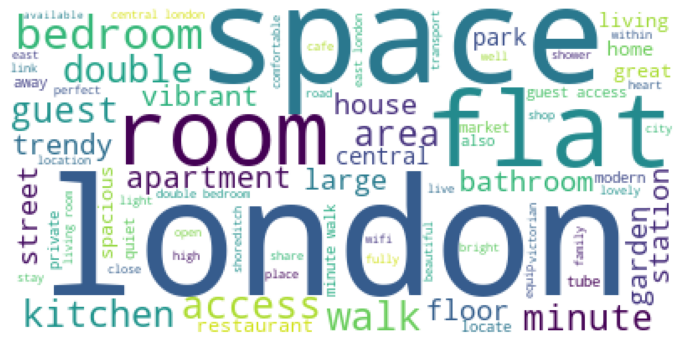

In [75]:
#MAKING THE WORD CLOUD
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(fcvdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

### Topic Modelling - Latent Dirchlet Allocation

In [76]:
#set the vectoriser
vectorizer = CountVectorizer(ngram_range=(1,2))

In [77]:
#calculate the topics
vectorizer.fit(corpus) 
tcorpus = vectorizer.transform(corpus) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=3, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

LatentDirichletAllocation(n_components=3, random_state=42)

In [78]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

(1000, 3)

In [79]:
pd.options.display.max_colwidth=20
gent1['Topic'] = topic_values.argmax(axis=1)
gent1.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry,description_norm,Topic
2,284532,COSY STUDIO-FLAT...,my very recently...,1481412,"London, United K...",1,3,Tower Hamlets,51.53,-0.07,Entire rental unit,Entire home/apt,90.00,5,365,POINT (-0.07426 ...,recently renovat...,1
5,107048,A Luxury Studio ...,situated in the ...,259088,United Kingdom,5,12,Islington,51.52,-0.10,Private room in ...,Private room,180.00,4,365,POINT (-0.10484 ...,situate heart vi...,0
12,117203,A stylish origin...,a very large and...,255103,"London, United K...",1,1,Hammersmith and ...,51.50,-0.23,Entire rental unit,Entire home/apt,136.00,5,90,POINT (-0.23300 ...,large light bedr...,1
28,142117,Stylish & Bright...,"newly decorated,...",192627,"London, United K...",2,2,Hackney,51.53,-0.09,Entire rental unit,Entire home/apt,180.00,3,1125,POINT (-0.08985 ...,newly decorate ...,1
35,143478,"Large room, Lond...",lovely bright do...,696065,"London, United K...",7,8,Hackney,51.54,-0.05,Private room in ...,Private room,35.00,1,730,POINT (-0.05457 ...,lovely bright do...,1


In [80]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(gent1[gent1.Topic==1].description.values) # tcorpus for transformed corpus

In [81]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names_out())

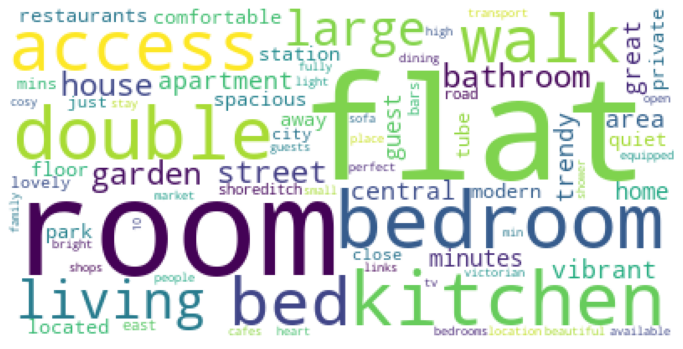

In [82]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf.sum())
plt.imshow(Cloud) 
plt.axis("off");